<a href="https://colab.research.google.com/github/NitCoh/NLPAss2/blob/master/NLP_Ass2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np

In [25]:
!wget 'https://www.cs.bgu.ac.il/~elhadad/nlp20/hw2_1_data.tar.gz'
!tar -xvzf hw2_1_data.tar.gz
!mv data ../
!wget https://www.cs.bgu.ac.il/~elhadad/nlp20/ngram_counts.txt.gz
!mv ngram_counts.txt.gz ../data/

--2020-01-10 10:11:51--  https://www.cs.bgu.ac.il/~elhadad/nlp20/hw2_1_data.tar.gz
Resolving www.cs.bgu.ac.il (www.cs.bgu.ac.il)... 132.72.41.239
Connecting to www.cs.bgu.ac.il (www.cs.bgu.ac.il)|132.72.41.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 435266 (425K) [application/x-gzip]
Saving to: ‘hw2_1_data.tar.gz.1’

hw2_1_data.tar.gz.1 100%[===================>] 425.06K   335KB/s    in 1.3s    

2020-01-10 10:11:54 (335 KB/s) - ‘hw2_1_data.tar.gz.1’ saved [435266/435266]

data/
data/complex_words_test_unlabeled.txt
data/.DS_Store
data/complex_words_development.txt
data/complex_words_training.txt
mv: cannot move 'data' to '../data': Directory not empty
--2020-01-10 10:12:00--  https://www.cs.bgu.ac.il/~elhadad/nlp20/ngram_counts.txt.gz
Resolving www.cs.bgu.ac.il (www.cs.bgu.ac.il)... 132.72.41.239
Connecting to www.cs.bgu.ac.il (www.cs.bgu.ac.il)|132.72.41.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44499414 (42M) [app

In [0]:
#############################################################
## ASSIGNMENT 2_1 CODE SKELETON
#############################################################

from collections import defaultdict
import gzip

#### Q1.1 Evaluation Metrics ####

## Input: y_pred, a list of length n with the predicted labels,
## y_true, a list of length n with the true labels

data_path = '../data'

## Calculates the precision of the predicted labels
def get_precision(y_pred, y_true):
  # For this assignment, complex words 1 are considered positive examples, and simple words 0 are considered negative examples.
    y_pred = [round(y) for y in y_pred]
    tp = len([x for x,y in zip(y_pred,y_true) if x==y==1])
    fp = len([x for x,y in zip(y_pred,y_true) if y==0 and x==1])
    precision = tp/(tp+fp)
    return precision
    
## Calculates the recall of the predicted labels
def get_recall(y_pred, y_true):
  
    ## YOUR CODE HERE...
    y_pred = [round(y) for y in y_pred]
    tp = len([x for x,y in zip(y_pred,y_true) if x==y==1])
    fn = len([x for x,y in zip(y_pred,y_true) if y==1 and x==0])
    recall = tp/(tp+fn)
    return recall

## Calculates the f-score of the predicted labels
def get_fscore(y_pred, y_true):
    ## YOUR CODE HERE...
    p = get_precision(y_pred,y_true)
    r = get_recall(y_pred,y_true)
    fscore = 2*p*r / (p +r)
    return fscore

def test_predictions(y_pred,y_true):
    p = get_precision(y_pred,y_true)
    r = get_recall(y_pred,y_true)
    f1 = get_fscore(y_pred,y_true)
    print("Precision:",p)
    print("Recall:",r)
    print("F-score:",f1)
    return p, r, f1

#### 2. Complex Word Identification ####

## Loads in the words and labels of one of the datasets
def load_file(data_file):
    words = []
    labels = []   
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
            i += 1
    return words, labels

### 1.2.1: A very simple baseline

## Labels every word complex
def all_complex(data_file):
    ## YOUR CODE HERE...
    _, y_true = load_file(data_file)
    y_pred = [1]*len(y_true)
    p, r, f1 = test_predictions(y_pred,y_true)

    performance = [p, r, f1]
    return performance



def threshold_plot_helper(training_file,development_file,pred,ts_range):
    p = []
    r = []
    f1= []
    train_words,train_labels = load_file(training_file)
    for threshold in ts_range:
      y_pred_train = [int(pred(x,threshold)) for x in train_words]
      p_t, r_t, f1_t = test_predictions(y_pred_train,train_labels)
      p.append(p_t)
      r.append(r_t)
      f1.append(f1_t)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.plot(r,p)

    best_index =  f1.index(max(f1))
    best_threshold = ts_range[best_index]
    print("Best threshold:",best_threshold)


    dev_words,dev_labels = load_file(development_file)
    y_pred_dev = [int(pred(x,best_threshold)) for x in dev_words]
    dprecision, drecall, dfscore = test_predictions(y_pred_dev,dev_labels)


    training_performance = [p[best_index], r[best_index], f1[best_index]]
    development_performance = [dprecision, drecall, dfscore]
    return training_performance, development_performance

### 1.2.2: Word length thresholding

## Finds the best length threshold by f-score, and uses this threshold to
## classify the training and development set
def word_length_threshold(training_file, development_file):

    func = lambda x,threshold: len(x) >= threshold
    return threshold_plot_helper(training_file,development_file,func,range(5,11))

### 1.2.3: Word frequency thresholding

## Loads Google NGram counts
def load_ngram_counts(ngram_counts_file): 
   counts = defaultdict(int) 
   with gzip.open(ngram_counts_file, 'rt', errors='ignore') as f: 
       for line in f:
           token, count = line.strip().split('\t') 
           if token[0].islower(): 
               counts[token] = int(count) 
   return counts

# Finds the best frequency threshold by f-score, and uses this threshold to
## classify the training and development set
def word_frequency_threshold(training_file, development_file, counts):
    func = lambda word,threshold : counts[word] >= threshold

    return threshold_plot_helper(training_file,development_file,func,range(100,8000,100))

### 1.3.1: Naive Bayes
        
## Trains a Naive Bayes classifier using length and frequency features
def naive_bayes(training_file, development_file, counts):
    ## YOUR CODE HERE
    training_performance = [tprecision, trecall, tfscore]
    development_performance = [dprecision, drecall, dfscore]
    return training_performance, development_performance

if __name__ == "__main__":
    training_file = "../data/complex_words_training.txt"
    development_file = "../data/complex_words_development.txt"
    test_file = "../data/complex_words_test_unlabeled.txt"
    train_data = load_file(training_file)
    

In [68]:
train_file_name = data_path+'/complex_words_training.txt'
dev_file_name = data_path+'/complex_words_development.txt'
all_complex(train_file_name)
all_complex(dev_file_name)

Precision: 0.43275
Recall: 1.0
F-score: 0.604083057058105
Precision: 0.418
Recall: 1.0
F-score: 0.5895627644569816


[0.418, 1.0, 0.5895627644569816]

Precision: 0.48284808302104354
Recall: 0.9676487579433853
F-score: 0.6442307692307692
Precision: 0.5379449294828744
Recall: 0.925476603119584
F-score: 0.680399235506477
Precision: 0.6007401315789473
Recall: 0.8440207972270364
F-score: 0.7018976699495555
Precision: 0.6785119378123264
Recall: 0.7059503177354131
F-score: 0.6919592298980747
Precision: 0.7456279809220986
Recall: 0.5418833044482958
F-score: 0.6276346604215458
Precision: 0.7696139476961394
Recall: 0.35701906412478335
F-score: 0.4877663772691396
Best threshold: 7
Precision: 0.6053511705685619
Recall: 0.8660287081339713
F-score: 0.7125984251968505


([0.6007401315789473, 0.8440207972270364, 0.7018976699495555],
 [0.6053511705685619, 0.8660287081339713, 0.7125984251968505])

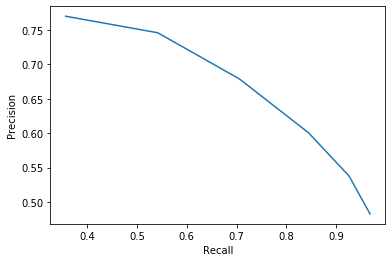

In [75]:
word_length_threshold(train_file_name,dev_file_name)

In [57]:
counts = load_ngram_counts(data_path+ngram_path)
avg = sum([val for val in counts.values()])/len(counts)
avg

155220.22442134944

In [59]:
counts['the']

47376829651

Precision: 0.4348279457768509
Recall: 0.9636048526863085
F-score: 0.5992455541584337
Precision: 0.4348279457768509
Recall: 0.9636048526863085
F-score: 0.5992455541584337
Precision: 0.4350547730829421
Recall: 0.9636048526863085
F-score: 0.5994609164420486
Precision: 0.4349073832507174
Recall: 0.9630271519352975
F-score: 0.5992092020129404
Precision: 0.43487340120073087
Recall: 0.9624494511842865
F-score: 0.5990650845019776
Precision: 0.43506663182649596
Recall: 0.9618717504332756
F-score: 0.5991363799928032
Precision: 0.4351803450078411
Recall: 0.9618717504332756
F-score: 0.5992441965089077
Precision: 0.4351803450078411
Recall: 0.9618717504332756
F-score: 0.5992441965089077
Precision: 0.43529411764705883
Recall: 0.9618717504332756
F-score: 0.599352051835853
Precision: 0.43529411764705883
Recall: 0.9618717504332756
F-score: 0.599352051835853
Precision: 0.4355218414857442
Recall: 0.9618717504332756
F-score: 0.5995678790061217
Precision: 0.4355218414857442
Recall: 0.9618717504332756
F-scor

([0.4358302776322682, 0.9612940496822646, 0.5997477022887007],
 [0.4227129337539432, 0.9617224880382775, 0.587289992695398])

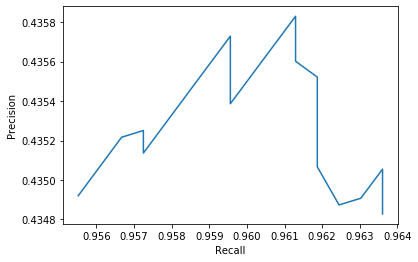

In [77]:
ngram_path = '/ngram_counts.txt.gz'

word_frequency_threshold(train_file_name,dev_file_name,counts)
